In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pyspark


import pyspark
from pyspark.sql import SparkSession


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import SQLTransformer

from pyspark.ml import Pipeline 
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import numpy as np
import time



cores_list = []
speedup_list = []
exec_times = []
for core in range(1,10):
                print("iter",core)
                serial_time = 144
                spark = SparkSession.builder.master('local['+str(core)+']').appName('Flight Delay Prediction').getOrCreate()
                flights_df = spark.read.csv('/content/drive/MyDrive/532/ProcessedFlights', sep=',', header=True, inferSchema=True, nullValue='NA')

                # Create an assembler object to consolidate the features
                relevantCols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'carrier_transformed', 'org_transformed', 'dest_transformed', 'tailnum_transformed']
                assembler = VectorAssembler(inputCols=relevantCols, outputCol='features')
                flights_consolidate = assembler.transform(flights_df)

                # # Selecting the features and delay values
                transformer = SQLTransformer(statement="SELECT ArrDelay, features FROM __THIS__")
                flights_data = transformer.transform(flights_consolidate)

                featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32).fit(flights_data)

                flights_train2, flights_test2 = flights_data.randomSplit([0.8, 0.2])

                time_init = time.time()

                #Creating GBT Regressor model 
                gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol="ArrDelay")
                pipeline2 = Pipeline(stages=[featureIndexer, gbt])

                paramGrid1 = (ParamGridBuilder() \
                    .addGrid(gbt.maxIter, [1]) \
                    .build())

                # Define the evaluator
                evaluator1 = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")

                # # Define the train-validation split
                train_validation_split_gbt = TrainValidationSplit(estimator=pipeline2, estimatorParamMaps=paramGrid1, evaluator=evaluator1, trainRatio=0.8)


                model_gbt = train_validation_split_gbt.fit(flights_train2)
                gbt_speed = time.time() - time_init
      
                speedup_list.append(serial_time/gbt_speed)
                exec_times.append(gbt_speed)
                cores_list.append(core)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


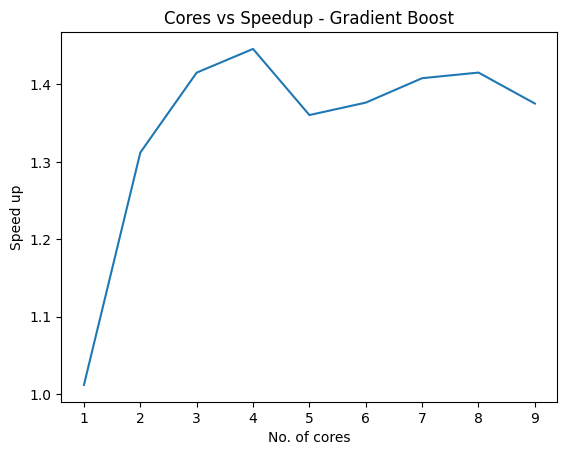

In [ ]:
import matplotlib.pyplot as plt
  
  
plt.plot(cores_list, speedup_list)
plt.xlabel('No. of cores')
plt.ylabel('Speed up')
  
plt.title('Cores vs Speedup - Gradient Boost')

plt.show()

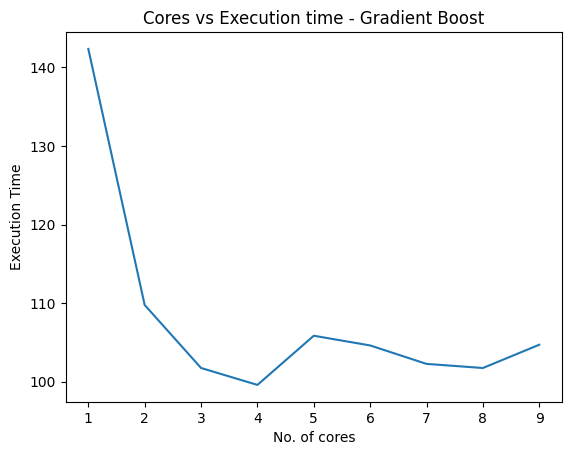

In [ ]:
plt.plot(cores_list, exec_times)
plt.xlabel('No. of cores')
plt.ylabel('Execution Time')
  
plt.title('Cores vs Execution time - Gradient Boost')

plt.show()